In [1]:
'''Required libraries'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import itertools

# 1.Data Loading & Preprocessing

In [2]:
def load_data(filepath: str) -> pd.DataFrame:
    data = pd.read_csv(filepath, parse_dates=True, index_col=0)
    return data

In [3]:
def preprocess_project_data(filepath,
                            sma_short_window=12,
                            sma_long_window=25,
                            volatility_window=5,
                            rsi_period=12,
                            ema_span=7,
                            boll_window=20,
                            boll_std_factor=2,
                            macd_short=12,
                            macd_long=26,
                            macd_signal=9,
                            split_date="2024-03-01"):
    """
    Loading the 'Trading_Project_Data_Cleaned.csv' which we cleaned in the data cleaning section. This function 
    computes the dividend-adjusted log returns and several technical indicators for each stock,
     and the data is split into training and testing sets.

    For each ticker (extracted from columns starting with "Close_"):
      - Dividend-adjusted log return is computed as:
              Adj_Return = ln((Close + Dividend) / Close.shift(1))
      - SMA_short and SMA_long (with periods 12 and 25, respectively) are computed.
      - Rolling volatility is computed on the adjusted return using a 5-day window.
      - RSI is computed over a 12-day period.
      - EMA of the closing price is computed with a span of 7.
      - Bollinger Bands (upper and lower) are computed using a 20-day window and a multiplier of 2.
      - MACD indicators computed using standard parameters:
            EMA12 (span=12), EMA26 (span=26), then MACD = EMA12 - EMA26, and
            MACD_Signal = EMA(MACD, span=9).


    Returns:
        tuple: (train_df, test_df) with all the computed technical indicators and the original data.
    """
    # Load and sort the base data.
    df = pd.read_csv(filepath)
    df["Price_Ticker"] = pd.to_datetime(df["Price_Ticker"])
    df = df.sort_values("Price_Ticker")
    df.set_index("Price_Ticker", inplace=True)
    print("Data loaded and sorted by date.")

    # Identify tickers from columns beginning with "Close_"
    tickers = sorted(set(col.replace("Close_", "") for col in df.columns if col.startswith("Close_")))
    print("Tickers found:", tickers)

    ticker_dfs = []

    def compute_RSI(series, period=7):
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()
        rs = avg_gain / (avg_loss.replace(0, np.nan))
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(100)

    for ticker in tickers:
        close_col = f"Close_{ticker}"
        if close_col not in df.columns:
            print(f"{close_col} not found; skipping {ticker}.")
            continue

        div_col = f"Dividends_{ticker}"
        dividends = df[div_col] if div_col in df.columns else pd.Series(0, index=df.index)
        dividends = dividends.fillna(0)

        # Compute dividend-adjusted log returns.
        adj_return = np.log((df[close_col] + dividends) / df[close_col].shift(1))
        df_adj = adj_return.to_frame(name=f"Adj_Return_{ticker}")

        # Compute SMA indices.
        sma_short = df[close_col].rolling(window=sma_short_window, min_periods=1).mean()
        sma_long = df[close_col].rolling(window=sma_long_window, min_periods=1).mean()
        df_sma = pd.concat([sma_short.rename(f"SMA_short_{ticker}"),
                            sma_long.rename(f"SMA_long_{ticker}")], axis=1)

        # Compute rolling volatility on dividend-adjusted return.
        volatility = df_adj[f"Adj_Return_{ticker}"].rolling(window=volatility_window, min_periods=1).std()
        df_vol = volatility.to_frame(name=f"Volatility_{ticker}")

        # Compute RSI.
        rsi = compute_RSI(df[close_col], period=rsi_period)
        df_rsi = rsi.to_frame(name=f"RSI_{ticker}")

        # Compute EMA.
        ema = df[close_col].ewm(span=ema_span, adjust=False).mean()
        df_ema = ema.to_frame(name=f"EMA_{ticker}")

        # Compute Bollinger Bands.
        boll_mid = df[close_col].rolling(window=boll_window, min_periods=1).mean()
        boll_std = df[close_col].rolling(window=boll_window, min_periods=1).std()
        boll_upper = boll_mid + boll_std_factor * boll_std
        boll_lower = boll_mid - boll_std_factor * boll_std
        df_boll = pd.concat([boll_upper.rename(f"BOLL_upper_{ticker}"),
                             boll_lower.rename(f"BOLL_lower_{ticker}")], axis=1)

        # Compute MACD
        exp1 = df[close_col].ewm(span=macd_short, adjust=False).mean()
        exp2 = df[close_col].ewm(span=macd_long, adjust=False).mean()
        macd_line = exp1 - exp2
        signal = macd_line.ewm(span=macd_signal, adjust=False).mean()
        df_macd = pd.concat([macd_line.rename(f"MACD_line_{ticker}"),
                             signal.rename(f"MACD_signal_{ticker}")], axis=1)

        # Concatenate indicators for this ticker.
        ticker_df = pd.concat([df_adj, df_sma, df_vol, df_rsi, df_ema, df_boll, df_macd], axis=1)
        ticker_dfs.append(ticker_df)
        print(f"Computed technical indicators for {ticker}.")

    # Join all ticker indicator DataFrames.
    technical_df = pd.concat(ticker_dfs, axis=1).copy()
    print("Technical indicators concatenated.")

    # Join with the original data.
    newframe = pd.concat([df, technical_df], axis=1).copy()

    # Split into training and testing sets.
    train_df = newframe.loc[newframe.index < split_date].copy()
    test_df  = newframe.loc[newframe.index >= split_date].copy()
    full_df = newframe.copy()
    print(f"Data split into {train_df.shape[0]} training rows and {test_df.shape[0]} testing rows.")

    return full_df, train_df, test_df

In [4]:
full_df, train_df, test_df = preprocess_project_data("data/Trading_Project_Data_Cleaned.csv")
test_df.head()

Data loaded and sorted by date.
Tickers found: ['AAPL', 'AMZN', 'BA', 'CAT', 'CVX', 'GOOGL', 'GS', 'JNJ', 'JPM', 'KO', 'MCD', 'MSFT', 'NKE', 'NVDA', 'PFE', 'SOFI', 'TSLA', 'UNH', 'WMT', 'XOM']
Computed technical indicators for AAPL.
Computed technical indicators for AMZN.
Computed technical indicators for BA.
Computed technical indicators for CAT.
Computed technical indicators for CVX.
Computed technical indicators for GOOGL.
Computed technical indicators for GS.
Computed technical indicators for JNJ.
Computed technical indicators for JPM.
Computed technical indicators for KO.
Computed technical indicators for MCD.
Computed technical indicators for MSFT.
Computed technical indicators for NKE.
Computed technical indicators for NVDA.
Computed technical indicators for PFE.
Computed technical indicators for SOFI.
Computed technical indicators for TSLA.
Computed technical indicators for UNH.
Computed technical indicators for WMT.
Computed technical indicators for XOM.
Technical indicators c

,Close_AAPL,Close_AMZN,Close_BA,Close_CAT,Close_CVX,Close_GOOGL,Close_GS,Close_JNJ,Close_JPM,Close_KO,...,Adj_Return_XOM,SMA_short_XOM,SMA_long_XOM,Volatility_XOM,RSI_XOM,EMA_XOM,BOLL_upper_XOM,BOLL_lower_XOM,MACD_line_XOM,MACD_signal_XOM
Price_Ticker,,,,,,,,,,,,,,,,,,,,,
2024-03-01,179.012268,178.220001,200.000000,331.704254,148.097229,136.644638,381.606262,158.338089,181.148910,57.765736,...,0.012550,101.460169,100.353412,0.005388,72.681418,102.018202,103.687525,97.280689,1.473991,1.436509
2024-03-04,174.468719,177.580002,200.539993,333.625275,144.288452,132.868347,385.686829,156.111267,182.507858,58.037441,...,-0.014082,101.746464,100.443534,0.009637,66.146848,101.977515,103.777759,97.515362,1.396503,1.428508
2024-03-05,169.506653,174.119995,201.139999,328.581268,144.976547,132.190796,384.369232,156.238251,184.336060,57.756035,...,0.012191,101.901811,100.578598,0.010824,60.279914,102.259320,103.984269,97.799300,1.419537,1.426714
2024-03-06,168.510254,173.509995,201.000000,330.650147,143.755402,130.925369,383.051666,155.622940,185.294174,57.785149,...,0.010640,102.149064,100.691247,0.011330,64.587356,102.746393,104.433147,97.883467,1.509385,1.443248
2024-03-07,168.390686,176.820007,203.029999,335.171997,144.763321,133.894623,381.930725,155.163895,183.671265,57.678410,...,0.005604,102.524825,100.906228,0.011228,73.008024,103.258098,104.921189,97.989932,1.609292,1.476457


In [5]:
train_df.head()

,Close_AAPL,Close_AMZN,Close_BA,Close_CAT,Close_CVX,Close_GOOGL,Close_GS,Close_JNJ,Close_JPM,Close_KO,...,Adj_Return_XOM,SMA_short_XOM,SMA_long_XOM,Volatility_XOM,RSI_XOM,EMA_XOM,BOLL_upper_XOM,BOLL_lower_XOM,MACD_line_XOM,MACD_signal_XOM
Price_Ticker,,,,,,,,,,,,,,,,,,,,,
2024-01-22,192.944748,154.779999,214.929993,284.386902,136.604904,145.462692,376.831573,157.484207,166.308197,57.804554,...,NaN,93.626274,93.626274,NaN,100.0,93.626274,NaN,NaN,0.000000,0.000000
2024-01-23,194.228455,156.020004,211.500000,284.544495,136.221420,146.508896,371.764343,154.905838,165.213226,58.076252,...,0.011195,94.153301,94.153301,NaN,100.0,93.889788,95.643959,92.662643,0.084084,0.016817
2024-01-24,193.551773,156.869995,214.130005,286.367065,138.934540,148.162903,370.426758,154.081940,166.689453,57.164120,...,0.017113,94.873726,94.873726,0.004185,100.0,94.495985,97.582816,92.164636,0.279371,0.069328
2024-01-25,193.223389,157.750000,201.880005,296.307312,142.433807,151.321442,373.648712,154.663498,169.074951,57.406708,...,0.025084,95.845573,95.845573,0.006970,100.0,95.562267,100.318222,91.372925,0.624355,0.180333
2024-01-26,191.481918,159.119995,205.470001,294.987213,142.980240,151.640289,368.854858,154.605347,168.429688,57.610481,...,0.008483,96.596944,96.596944,0.007354,100.0,96.572307,101.724768,91.469119,0.954640,0.335195


# 2. Stock Selection

In [6]:
def stock_selection(train_df):
    """
    Selects stocks based on three criteria computed from the preprocessed data:
      1. Volatility: Standard deviation of the dividend-adjusted log returns.
      2. Lower average correlation: Each stock's average correlation with other stocks based on
         dividend-adjusted returns (lower is better).
      3. Average return: Mean of the dividend-adjusted log returns (higher is better).

    For each ticker (identified from columns "Adj_Return_{ticker}"):
      - Compute volatility and average return.
      - Build a DataFrame from all dividend-adjusted returns to compute the correlation matrix,
        and then compute each stock's average correlation with the others.

    Stocks are then ranked by:
      - Volatility (higher is better → descending rank).
      - Average return (higher is better → descending rank).
      - Average correlation (lower is better → ascending rank).

    The composite ranking is the average of these three individual ranks.
    The function prints the rankings for each metric and returns the top 10 tickers based on
    the composite rank.

    Return:
             the top 10 tickers based on the composite rank.
    """
    tickers = sorted(set(col.replace("Adj_Return_", "") for col in train_df.columns if col.startswith("Adj_Return_")))

    metrics = []
    adj_return_dict = {}

    for ticker in tickers:
        col = f"Adj_Return_{ticker}"
        if col in train_df.columns:
            series = train_df[col].dropna()
            if len(series) > 1:
                vol = series.std()
                avg_ret = series.mean()
                adj_return_dict[ticker] = series
                metrics.append({
                    "ticker": ticker,
                    "volatility": vol,
                    "avg_return": avg_ret
                })
            else:
                print(f"Not enough data for {ticker}; skipping.")
        else:
            print(f"{col} not found for {ticker}.")

    metrics_df = pd.DataFrame(metrics)

    # Build DataFrame of all dividend-adjusted returns for correlation calculation.
    adj_returns_df = pd.DataFrame({ticker: adj_return_dict[ticker] for ticker in adj_return_dict}).dropna()
    corr_matrix = adj_returns_df.corr()

    avg_corr = {}
    for ticker in corr_matrix.columns:
        avg_corr[ticker] = (corr_matrix[ticker].sum() - 1) / (len(corr_matrix) - 1)
    metrics_df["avg_corr"] = metrics_df["ticker"].map(avg_corr)

    # Ranking:
    metrics_df["vol_rank"] = metrics_df["volatility"].rank(ascending=False, method="min")
    metrics_df["ret_rank"] = metrics_df["avg_return"].rank(ascending=False, method="min")
    metrics_df["corr_rank"] = metrics_df["avg_corr"].rank(ascending=True, method="min")

    metrics_df["composite_rank"] = (metrics_df["vol_rank"] + metrics_df["ret_rank"] + metrics_df["corr_rank"]) / 3

    print("Ranking by Volatility (higher is better):")
    for _, row in metrics_df.sort_values("vol_rank").iterrows():
        print(f"{row['ticker']}: Volatility = {row['volatility']:.5f}, Vol_Rank = {row['vol_rank']:.1f}")

    print("\nRanking by Average Correlation (lower is better):")
    for _, row in metrics_df.sort_values("corr_rank").iterrows():
        print(f"{row['ticker']}: Avg Corr = {row['avg_corr']:.5f}, Corr_Rank = {row['corr_rank']:.1f}")

    print("\nRanking by Average Return (higher is better):")
    for _, row in metrics_df.sort_values("ret_rank").iterrows():
        print(f"{row['ticker']}: Avg Return = {row['avg_return']:.5f}, Ret_Rank = {row['ret_rank']:.1f}")

    print("\nComposite Ranking (lower is better):")
    comp_sorted = metrics_df.sort_values("composite_rank")
    for _, row in comp_sorted.iterrows():
        print(f"{row['ticker']}: Composite Rank = {row['composite_rank']:.1f}")

    top10 = comp_sorted.head(10)["ticker"].tolist()
    print("\nTop 10 Selected Tickers:")
    print(top10)
    return top10

In [7]:
top10_tickers = stock_selection(train_df)

Ranking by Volatility (higher is better):
SOFI: Volatility = 0.05138, Vol_Rank = 1.0
NVDA: Volatility = 0.03588, Vol_Rank = 2.0
TSLA: Volatility = 0.03439, Vol_Rank = 3.0
GOOGL: Volatility = 0.02121, Vol_Rank = 4.0
AMZN: Volatility = 0.02028, Vol_Rank = 5.0
BA: Volatility = 0.01947, Vol_Rank = 6.0
CAT: Volatility = 0.01456, Vol_Rank = 7.0
NKE: Volatility = 0.01400, Vol_Rank = 8.0
CVX: Volatility = 0.01387, Vol_Rank = 9.0
UNH: Volatility = 0.01347, Vol_Rank = 10.0
MSFT: Volatility = 0.01262, Vol_Rank = 11.0
GS: Volatility = 0.01230, Vol_Rank = 12.0
XOM: Volatility = 0.01226, Vol_Rank = 13.0
PFE: Volatility = 0.01208, Vol_Rank = 14.0
MCD: Volatility = 0.01120, Vol_Rank = 15.0
WMT: Volatility = 0.01039, Vol_Rank = 16.0
AAPL: Volatility = 0.00861, Vol_Rank = 17.0
KO: Volatility = 0.00855, Vol_Rank = 18.0
JPM: Volatility = 0.00805, Vol_Rank = 19.0
JNJ: Volatility = 0.00769, Vol_Rank = 20.0

Ranking by Average Correlation (lower is better):
BA: Avg Corr = -0.05220, Corr_Rank = 1.0
UNH: Avg C

# 3. Strategies

In [8]:
class BaseStrategy():
    def __init__(self, ticker: str, initial_investment: float, **kwargs):
        """
        Base class for trading strategies.

        Parameters:
            ticker (str): Stock symbol (e.g., "AAPL").
            initial_investment (float): Capital allocated for the strategy.
            kwargs: Additional strategy-specific parameters.
        """
        self.ticker = ticker
        self.initial_investment = initial_investment
        self.params = kwargs
        self.name = self.__class__.__name__
        self.results = None

    #abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """
        Generate trading signals.
        Should return a pandas Series indexed by date, with +1 for long and -1 for short.
        """
        pass

    #abstractmethod
    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Run a simulation on historical data.

        Returns a DataFrame with columns: 'Signal', 'SimpleReturn', 'Position', 'Equity'.
        """
        pass

    def simulate_benchmark(self, data: pd.DataFrame) -> pd.Series:
        """
        Simulate a benchmark strategy (always long).

        Uses effective log returns computed as:
            ln((Close + Dividend) / Close.shift(1))
        and then updates the equity curve.
        """
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1

        benchmark_equity = pd.Series(index=prices.index, dtype=float)
        benchmark_equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            benchmark_equity.iloc[t] = benchmark_equity.iloc[t-1] * (1 + simple_ret.iloc[t])
        return benchmark_equity

    def plot_results(self, data: pd.DataFrame):
        """
        Plot the strategy's equity curve alongside the benchmark, as well as positions and signals.
        """
        if self.results is None:
            print("No simulation results available. Run simulate() first.")
            return

        dates = self.results.index
        strategy_equity = self.results["Equity"]
        signals = self.results["Signal"]
        benchmark_equity = self.simulate_benchmark(data)

        fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

        # Equity Curve Plot
        ax[0].plot(dates, strategy_equity, label=f"{self.name} Equity")
        ax[0].plot(dates, benchmark_equity, label="Benchmark (Always Long)", linestyle="--")
        ax[0].set_title(f"Equity Curve for {self.ticker}")
        ax[0].set_ylabel("Equity ($)")
        ax[0].legend()
        ax[0].grid(True)

        # Position Plot
        ax[1].plot(dates, self.results["Position"], label="Position", color="tab:orange")
        ax[1].set_title("Daily Trading Position")
        ax[1].set_ylabel("Position (Fraction)")
        ax[1].legend()
        ax[1].grid(True)


        plt.tight_layout()
        plt.show()

In [9]:
class BenchmarkStrategy:
    def __init__(self, ticker: str, initial_investment: float):
        """
        Benchmark strategy: always long.
        """
        self.ticker = ticker
        self.initial_investment = initial_investment
        self.name = "BenchmarkStrategy"
        self.results = None

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + simple_ret.iloc[t])
        signals = pd.Series(1, index=data.index)  # always long
        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": pd.Series(1, index=data.index),
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

    def plot_results(self, data: pd.DataFrame):
        if self.results is None:
            print("No simulation results available. Run simulate() first.")
            return
        dates = self.results.index
        equity = self.results["Equity"]
        fig, ax = plt.subplots(figsize=(12,6))
        ax.plot(dates, equity, label="Benchmark Equity")
        ax.set_title(f"Benchmark Equity Curve for {self.ticker}")
        ax.set_ylabel("Equity ($)")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()


## (a) SMA

In [10]:
class SMAStrategy(BaseStrategy):
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        sma_short_col = f"SMA_short_{self.ticker}"
        sma_long_col = f"SMA_long_{self.ticker}"
        if sma_short_col not in data.columns or sma_long_col not in data.columns:
            raise ValueError(f"SMA columns missing for {self.ticker}.")
        sma_short = data[sma_short_col]
        sma_long = data[sma_long_col]
        signals = np.where(sma_short > sma_long, 1, -1)
        return pd.Series(signals, index=data.index)

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1
        signals = self.generate_signals(data)
        positions = signals

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + positions.iloc[t-1] * simple_ret.iloc[t])

        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": positions,
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

# (b) RSI

In [11]:
class RSIStrategy(BaseStrategy):
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        rsi_col = f"RSI_{self.ticker}"
        if rsi_col not in data.columns:
            raise ValueError(f"RSI column for {self.ticker} missing.")
        rsi_values = data[rsi_col]
        signals = []
        prev_signal = 1  # default long signal for the first day
        for rsi in rsi_values:
            if rsi < 30:
                signal = 1
            elif rsi > 70:
                signal = -1
            else:
                signal = prev_signal
            signals.append(signal)
            prev_signal = signal
        return pd.Series(signals, index=data.index)

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1
        signals = self.generate_signals(data)
        positions = signals

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + positions.iloc[t-1] * simple_ret.iloc[t])

        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": positions,
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

# (c) EMA

In [12]:
class EMAStrategy(BaseStrategy):
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        ema_col = f"EMA_{self.ticker}"
        close_col = f"Close_{self.ticker}"
        if ema_col not in data.columns:
            raise ValueError(f"EMA column for {self.ticker} missing.")
        prices = data[close_col]
        ema = data[ema_col]
        signals = np.where(prices > ema, 1, -1)
        return pd.Series(signals, index=data.index)

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1
        signals = self.generate_signals(data)
        positions = signals

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + positions.iloc[t-1] * simple_ret.iloc[t])

        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": positions,
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

# (d) Bollinger Band

In [13]:
class BollStrategy(BaseStrategy):
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        close_col = f"Close_{self.ticker}"
        upper_col = f"BOLL_upper_{self.ticker}"
        lower_col = f"BOLL_lower_{self.ticker}"
        if close_col not in data.columns or upper_col not in data.columns or lower_col not in data.columns:
            raise ValueError(f"Bollinger Bands columns missing for {self.ticker}.")
        prices = data[close_col]
        upper = data[upper_col]
        lower = data[lower_col]
        signals = []
        init_signal = 1  # default long on the first day
        prev_signal = init_signal
        for price, up, low in zip(prices, upper, lower):
            if price < low:
                sig = 1
            elif price > up:
                sig = -1
            elif prev_signal == -1 and price < up:
                sig = 1
            else:
                sig = prev_signal
            signals.append(sig)
            prev_signal = sig
        return pd.Series(signals, index=data.index)

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1
        signals = self.generate_signals(data)
        positions = signals

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + positions.iloc[t-1] * simple_ret.iloc[t])

        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": positions,
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

# (e) MACD

In [14]:
class MACDStrategy(BaseStrategy):
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        close_col = f"Close_{self.ticker}"
        if close_col not in data.columns:
            raise ValueError(f"Close column for {self.ticker} missing.")
        prices = data[close_col]
        # Use default MACD parameters or ones passed via self.params.
        macd_short = self.params.get("macd_short", 12)
        macd_long = self.params.get("macd_long", 26)
        macd_signal = self.params.get("macd_signal", 9)
        ema_short = prices.ewm(span=macd_short, adjust=False).mean()
        ema_long = prices.ewm(span=macd_long, adjust=False).mean()
        macd_line = ema_short - ema_long
        signal_line = macd_line.ewm(span=macd_signal, adjust=False).mean()

        signals = []
        prev_signal = 1  # default long signal
        for m, s in zip(macd_line, signal_line):
            if m > s:
                sig = 1
            elif m < s:
                sig = -1
            else:
                sig = prev_signal
            signals.append(sig)
            prev_signal = sig
        return pd.Series(signals, index=data.index)

    def simulate(self, data: pd.DataFrame) -> pd.DataFrame:
        close_col = f"Close_{self.ticker}"
        div_col = f"Dividends_{self.ticker}"
        if close_col not in data.columns:
            raise ValueError(f"Close column for {self.ticker} missing.")
        prices = data[close_col]
        dividends = data.get(div_col, pd.Series(0, index=data.index)).fillna(0)
        log_returns = np.log((prices + dividends) / prices.shift(1))
        simple_ret = np.exp(log_returns) - 1
        signals = self.generate_signals(data)
        positions = signals

        equity = pd.Series(index=data.index, dtype=float)
        equity.iloc[0] = self.initial_investment
        for t in range(1, len(prices)):
            equity.iloc[t] = equity.iloc[t-1] * (1 + positions.iloc[t-1] * simple_ret.iloc[t])

        results = pd.DataFrame({
            "Signal": signals,
            "SimpleReturn": simple_ret,
            "Position": positions,
            "Equity": equity
        }, index=data.index)
        self.results = results
        return results

# Stock NVD as example for technical indicators

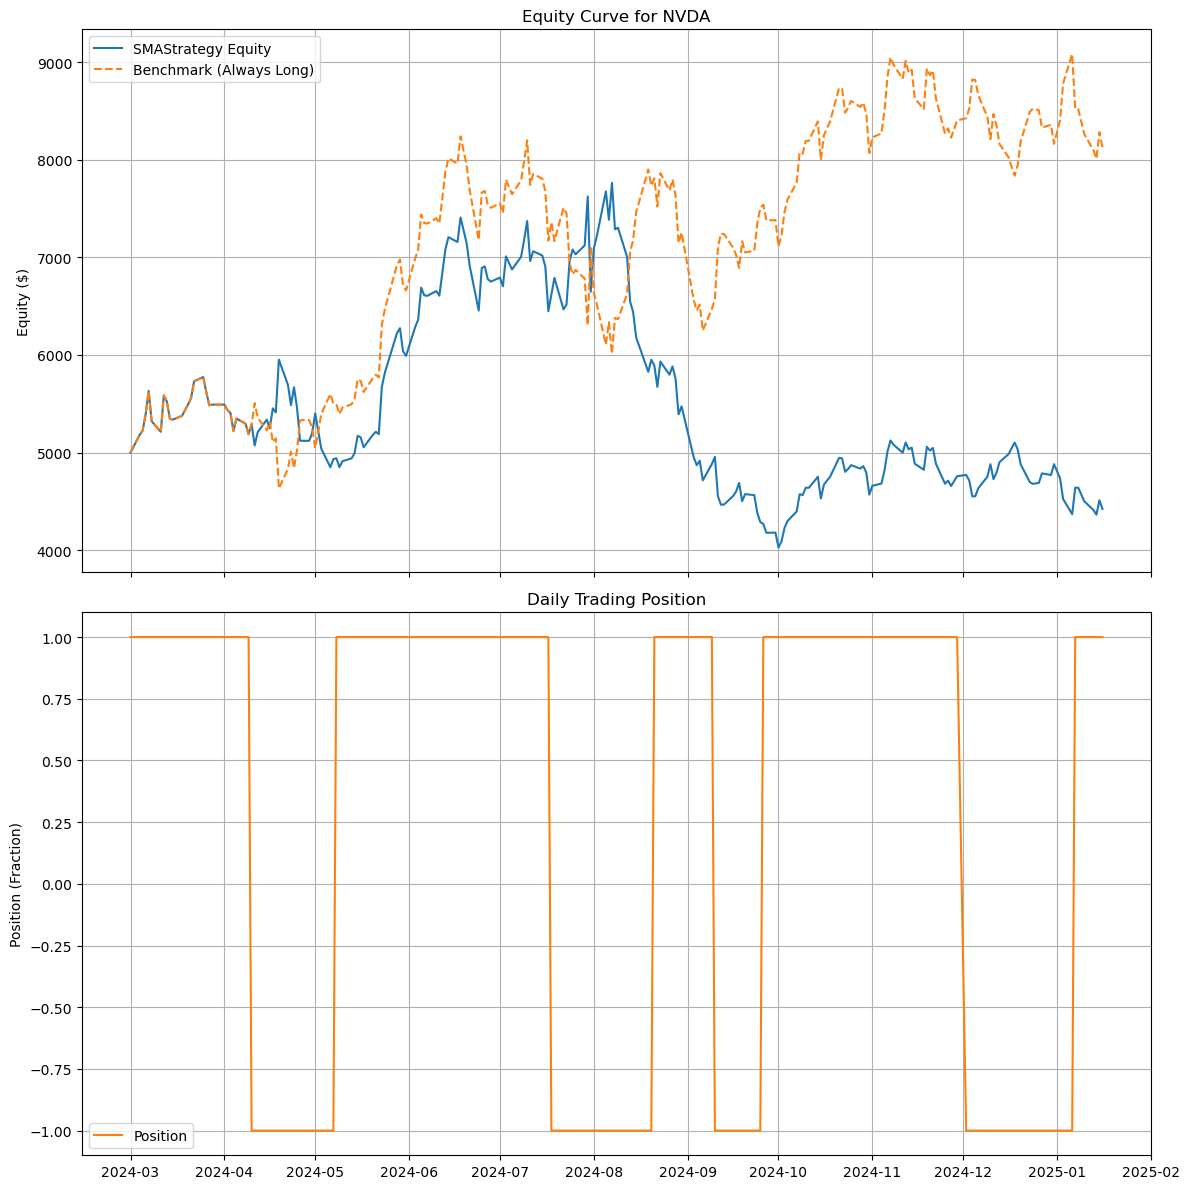

In [15]:
sma_strategy_example = SMAStrategy(ticker="NVDA", initial_investment=5000)
results_sma = sma_strategy_example.simulate(test_df)
sma_strategy_example.plot_results(test_df)

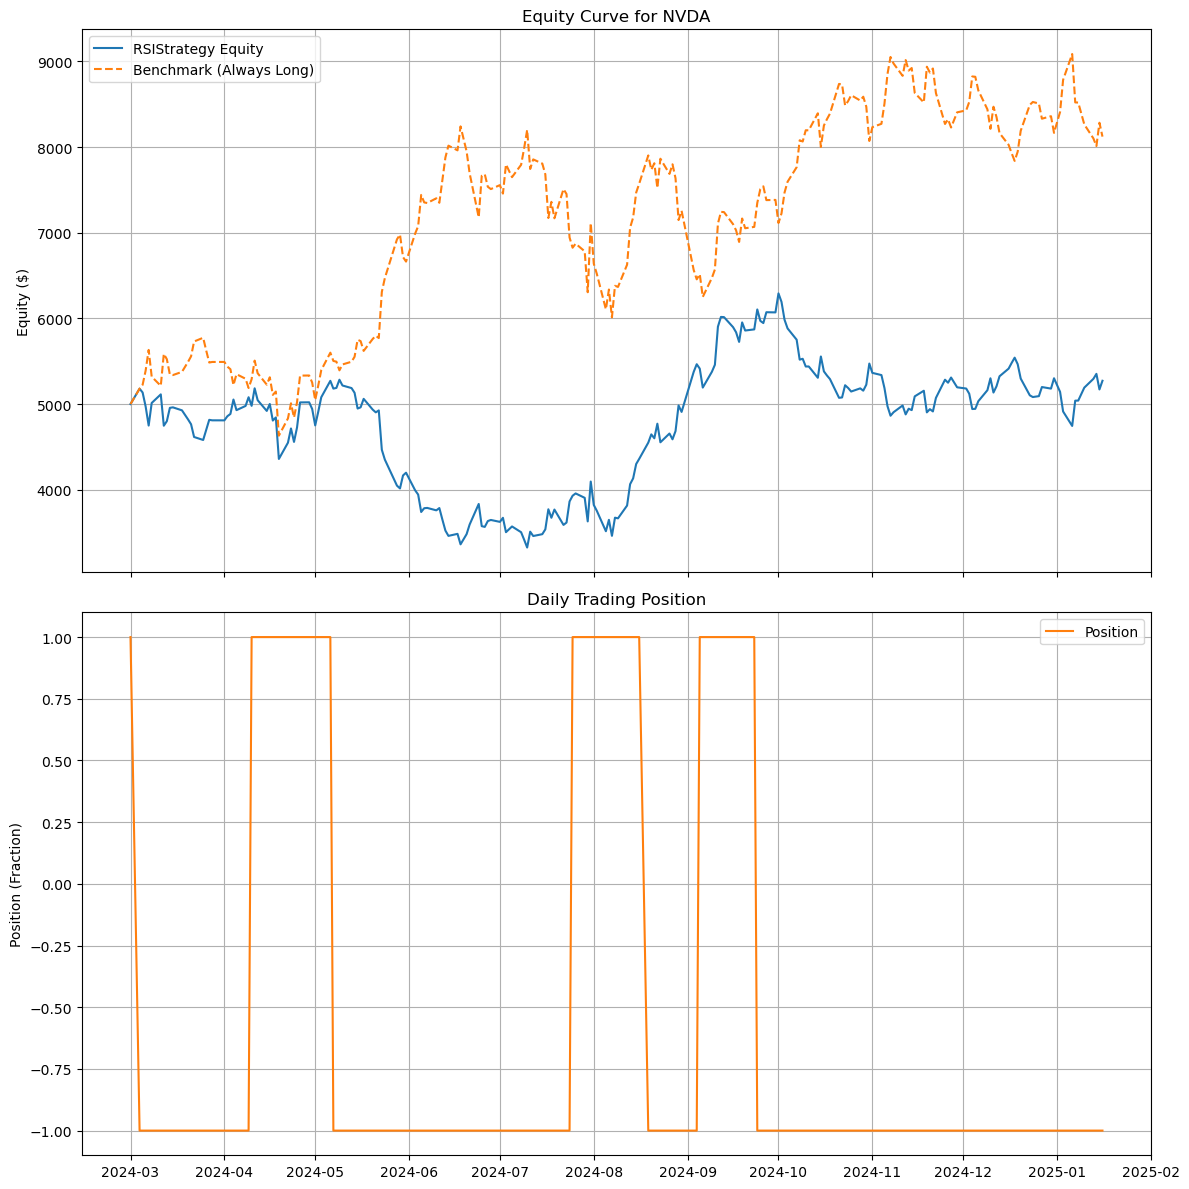

In [16]:
RSI_strategy_example = RSIStrategy(ticker="NVDA", initial_investment=5000)
results_RSI = RSI_strategy_example.simulate(test_df)
RSI_strategy_example.plot_results(test_df)

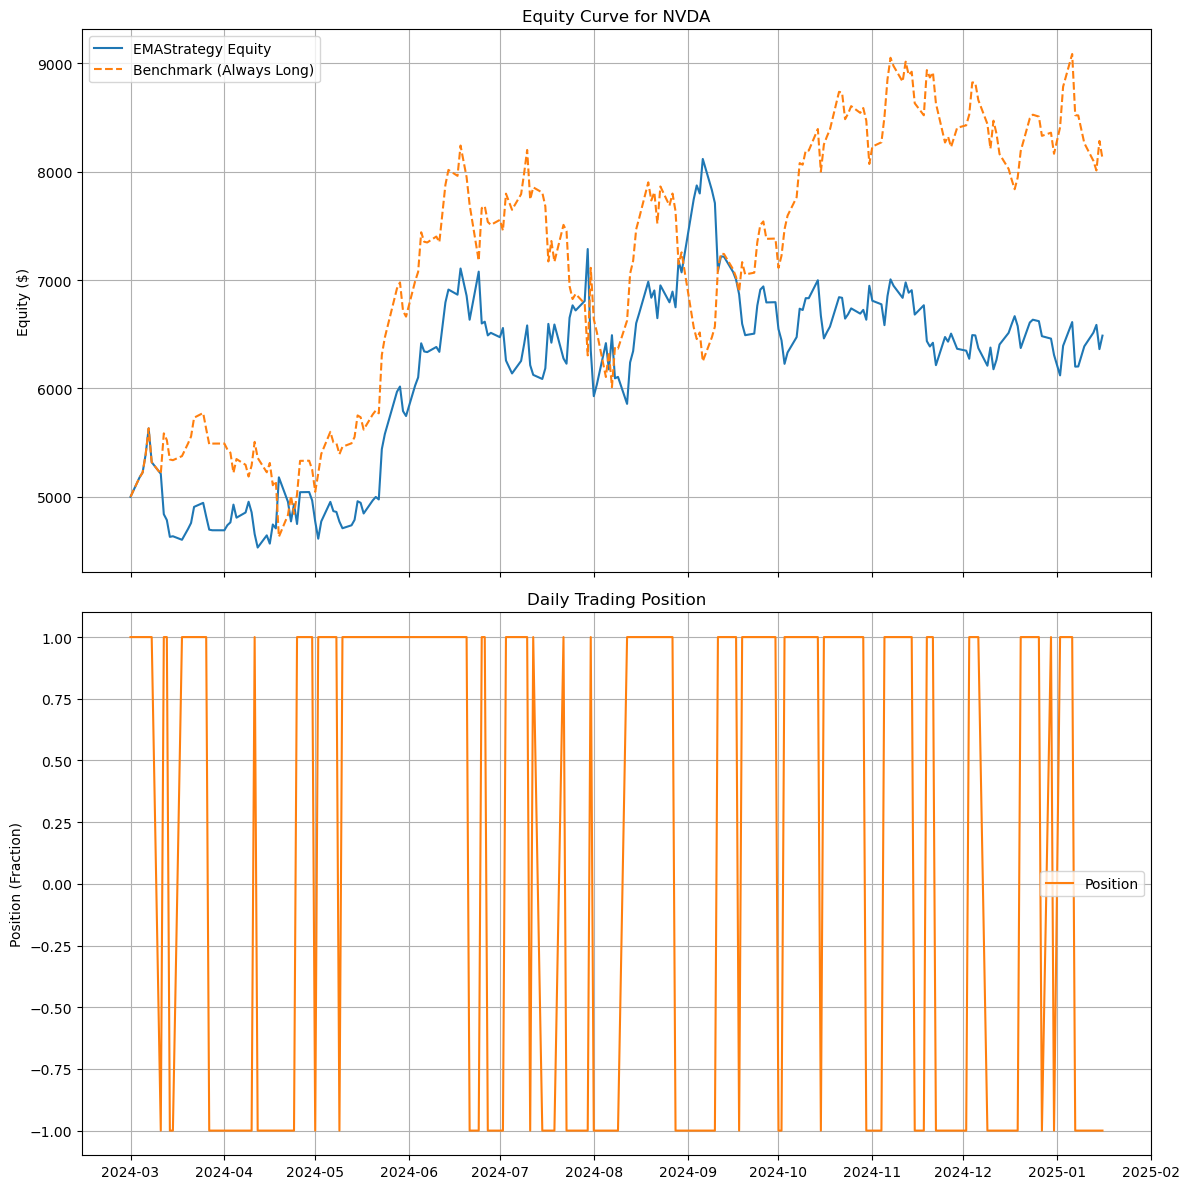

In [17]:
EMA_strategy_example = EMAStrategy(ticker="NVDA", initial_investment=5000)
results_EMA = EMA_strategy_example.simulate(test_df)
EMA_strategy_example.plot_results(test_df)

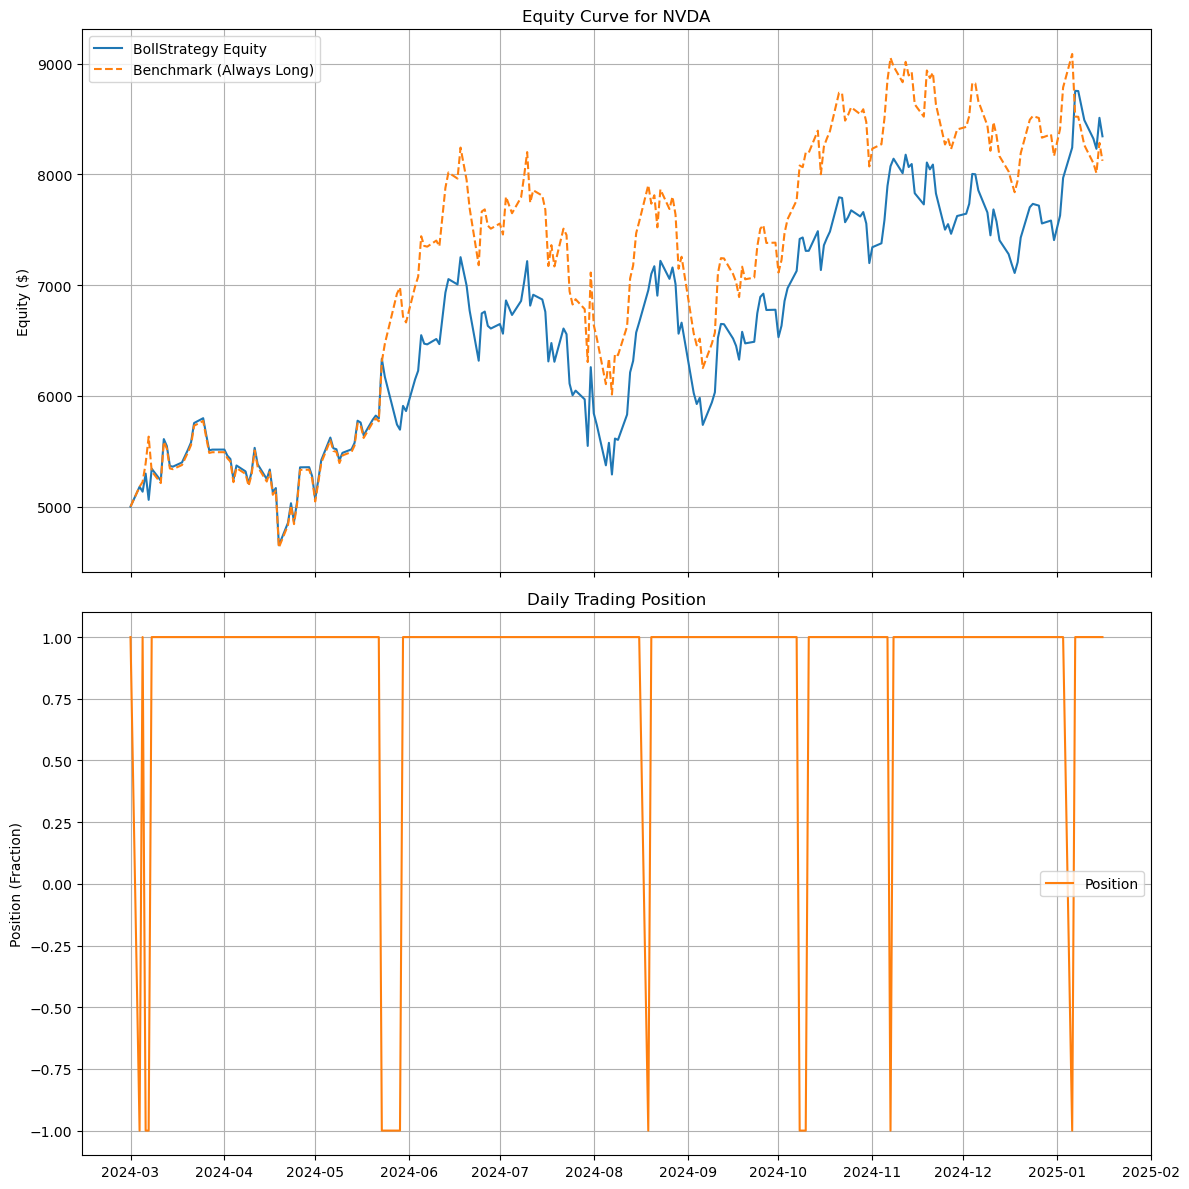

In [18]:
Boll_strategy_example = BollStrategy(ticker="NVDA", initial_investment=5000)
results_Boll = Boll_strategy_example.simulate(test_df)
Boll_strategy_example.plot_results(test_df)

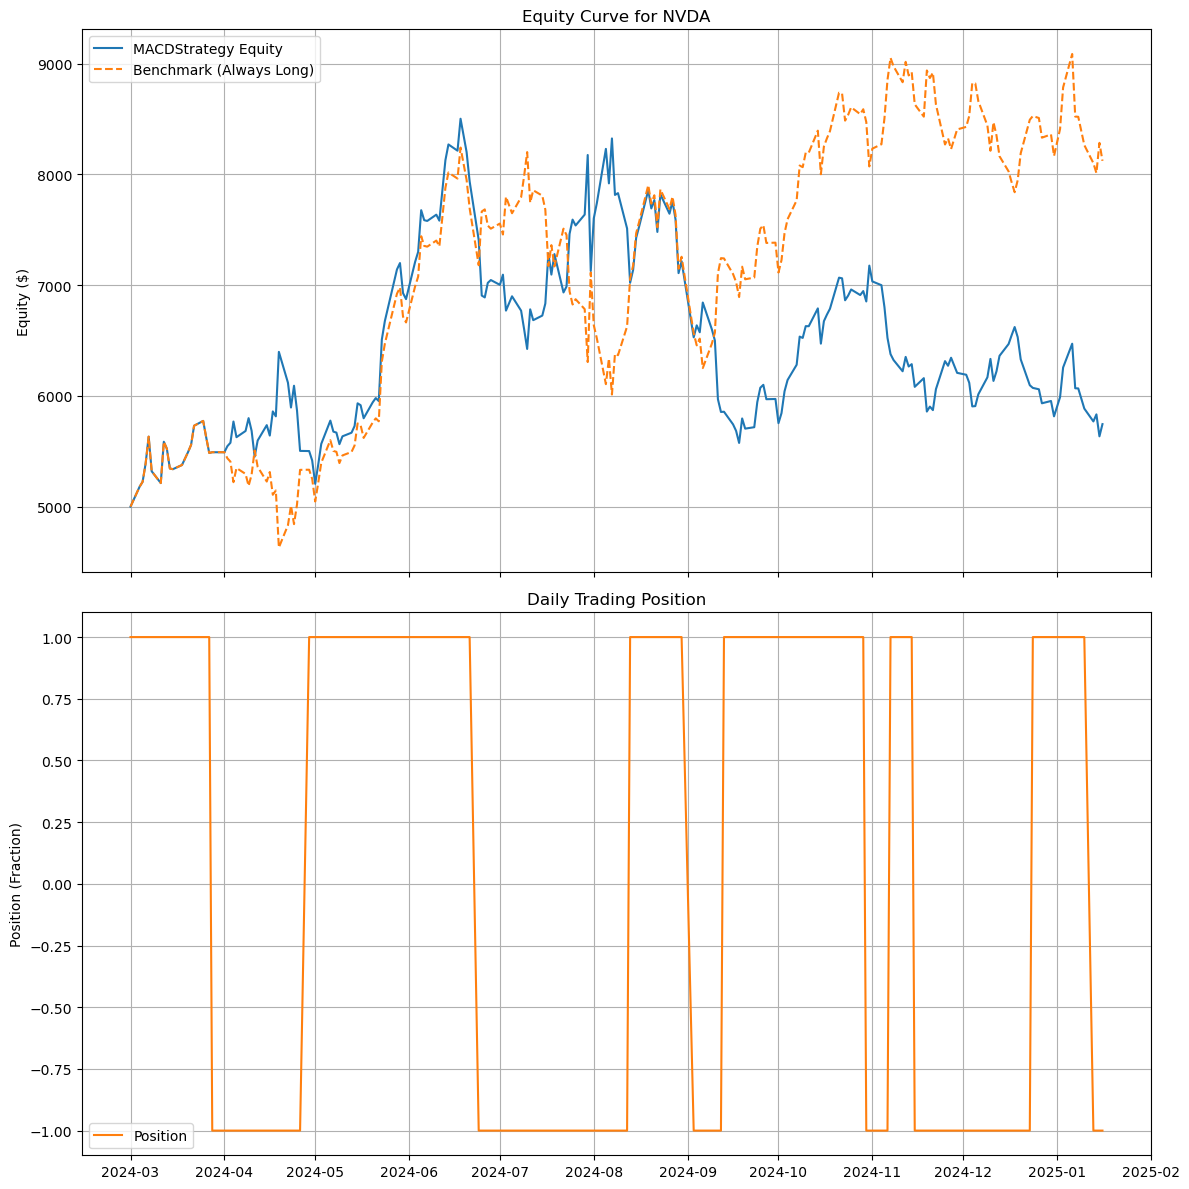

In [19]:
MACD_strategy_example = MACDStrategy(ticker="NVDA", initial_investment=5000)
results_MACD = MACD_strategy_example.simulate(test_df)
MACD_strategy_example.plot_results(test_df)

# 4. Stock Analysis

In [20]:
def compute_strategy_weights(ticker, data, initial_investment=5000):
    """
    Computes strategy weights from the combined data.

    For the six strategies (SMA, RSI, EMA, Boll, MACD, Benchmark),
    this function simulates each on the provided data, computes the cumulative
    log return (i.e. ln(final equity/initial investment)) for each, and then:
      - Sets a raw value of zero for strategies with negative log returns.
      - Computes raw proportions.
      - Assigns the Benchmark a final weight of 0.33 + (p_benchmark * 0.66) and
        all others a weight of p_i * 0.66.
    Finally, the weights are normalized (if necessary) so they sum to 1.

    Returns:
        dict: Final weights for strategies.
    """
    # Instantiate individual strategy objects.
    strat_objs = {
        "SMA": SMAStrategy(ticker=ticker, initial_investment=initial_investment, sma_short_window=7, sma_long_window=25),
        "RSI": RSIStrategy(ticker=ticker, initial_investment=initial_investment),
        "EMA": EMAStrategy(ticker=ticker, initial_investment=initial_investment),
        "BOLL": BollStrategy(ticker=ticker, initial_investment=initial_investment),
        "MACD": MACDStrategy(ticker=ticker, initial_investment=initial_investment),
        "Benchmark": BenchmarkStrategy(ticker=ticker, initial_investment=initial_investment)
    }

    cum_log_returns = {}
    # Simulate each strategy on the updated combined data.
    for name, obj in strat_objs.items():
        result = obj.simulate(data)
        final_equity = result["Equity"].iloc[-1]
        r = np.log(final_equity / initial_investment)
        cum_log_returns[name] = r if r > 0 else 0  # assign zero if negative.
        print(f"{name} cumulative log return: {r:.4f}")

    total_raw = sum(cum_log_returns.values())
    if total_raw > 0:
        raw_props = {name: cum_log_returns[name] / total_raw for name in cum_log_returns}
    else:
        raw_props = {name: 1/len(cum_log_returns) for name in cum_log_returns}

    final_weights = {}
    for name in raw_props:
        if name == "Benchmark":
            final_weights[name] = 1/3 + (raw_props[name] * 2/3)
        else:
            final_weights[name] = raw_props[name] * 2/3
    total_weight = sum(final_weights.values())
    final_weights = {name: weight/total_weight for name, weight in final_weights.items()}

    print("Updated weights:", final_weights)
    return final_weights

In [21]:
def dynamic_mixed_strategy(ticker, train_df, test_df, initial_investment=5000, update_interval=1):
    """
    Dynamically updates mixed strategy weights every 'update_interval' trading day(s).

    For update_interval = 1, each block consists of a single day. In each block,
    the current training data (initially train_df and then augmented by prior test blocks)
    is combined with the new day from test_df. New strategy weights are computed via
    compute_strategy_weights, then each individual strategy is simulated on the combined data.
    The results corresponding to the one-day block are extracted; from these, the weighted daily
    log return is computed and converted to an equity value, starting from the previous block's ending equity.

    Finally, the overall mixed equity time series is plotted (together with the Benchmark) and a tuple
    (simulation_df, benchmark_equity) is returned.

    Returns:
         tuple: (simulation_df, benchmark_equity)
            - simulation_df: a DataFrame indexed by date with columns “Position”, “Equity”, “SimpleReturn”.
            - benchmark_equity: benchmark’s simulated equity time series.
    """
    # Ensure test_df is sorted by date.
    test_df = test_df.sort_index()
    current_train = train_df.copy()
    current_equity = initial_investment
    mixed_dates = []
    mixed_equities = []
    mixed_positions = []

    n = len(test_df)
    # Loop through test data one day at a time.
    for start in range(0, n, update_interval):
        block = test_df.iloc[start : start + update_interval]
        # Because update_interval==1, block has one day.
        updated_data = pd.concat([current_train, block]).sort_index()
        # Compute new strategy weights on the full updated data.
        new_weights = compute_strategy_weights(ticker, updated_data, initial_investment)
        print(f"New weights for block starting {block.index[0]}: {new_weights}")

        strat_objs = {
            "SMA": SMAStrategy(ticker=ticker, initial_investment=initial_investment, sma_short_window=7, sma_long_window=25),
            "RSI": RSIStrategy(ticker=ticker, initial_investment=initial_investment),
            "EMA": EMAStrategy(ticker=ticker, initial_investment=initial_investment),
            "BOLL": BollStrategy(ticker=ticker, initial_investment=initial_investment),
            "MACD": MACDStrategy(ticker=ticker, initial_investment=initial_investment),
            "Benchmark": BenchmarkStrategy(ticker=ticker, initial_investment=initial_investment)
        }

        block_daily_log_rets = {}
        block_positions = {}
        for name, obj in strat_objs.items():
            sim_res = obj.simulate(updated_data)
            # Extract only the row corresponding to the current block day.
            block_res = sim_res.loc[block.index]
            # Compute daily log return; if only one row is present, then after .shift(1) it becomes NaN, fill with 0.
            lr = np.log(block_res["Equity"] / block_res["Equity"].shift(1)).fillna(0)
            block_daily_log_rets[name] = lr
            block_positions[name] = block_res["Position"]

        # Compute weighted daily log return.
        mixed_block_lr = sum(new_weights[name] * block_daily_log_rets[name] for name in new_weights)
        # Also compute a weighted average position.
        mixed_block_pos = sum(new_weights[name] * block_positions[name] for name in new_weights)
        # Even if the block has a single day, cumsum() works fine.
        block_cum_lr = mixed_block_lr.cumsum()
        block_equity = current_equity * np.exp(block_cum_lr)

        mixed_dates.extend(block_equity.index)
        mixed_equities.extend(block_equity.values)
        mixed_positions.extend(mixed_block_pos.values)

        current_equity = block_equity.iloc[-1]
        # Append current day block to training set for future updates.
        current_train = pd.concat([current_train, block]).sort_index()

    # Build simulation DataFrame.
    simulation_df = pd.DataFrame({
        "Position": mixed_positions,
        "Equity": mixed_equities
    }, index=mixed_dates)
    simulation_df["SimpleReturn"] = simulation_df["Equity"] / initial_investment

    # Simulate benchmark equity curve on the entire test data.
    bench = BenchmarkStrategy(ticker=ticker, initial_investment=initial_investment)
    bench.simulate(test_df)
    benchmark_equity = bench.results["Equity"]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.plot(simulation_df.index, simulation_df["Equity"], label="Dynamic Mixed Strategy", linestyle="--", linewidth=2, color="black")
    plt.plot(benchmark_equity.index, benchmark_equity, label="Benchmark", linestyle="--")
    plt.title(f"Dynamic Mixed Strategy Equity Curve for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Equity ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Final Benchmark Strategy return: {benchmark_equity.iloc[-1]/initial_investment:.2f}")
    print(f"Final Mixed Strategy return: {simulation_df['Equity'].iloc[-1]/initial_investment:.2f}")

    return simulation_df, benchmark_equity


In [22]:
def generate_dynamic_mixed_strategy_portfolio(tickers, train_df, test_df, initial_investment=5000, update_interval=1):
    """
    For each ticker, runs the dynamic mixed strategy simulation using update_interval=1.
    It generates the equity curve for each ticker, plots it, and stores the simulation DataFrame
    as well as computing the simple return for each ticker.

    Returns:
         tuple: (simulation_results, simple_returns)
              - simulation_results: dict mapping ticker to its dynamic mixed strategy simulation DataFrame.
              - simple_returns: dict mapping ticker to its simple return (final equity/initial_investment).
    """
    simulation_results = {}
    simple_returns = {}
    for ticker in tickers:
        print(f"\n--- Processing {ticker} ---")
        sim_df, benchmark_equity = dynamic_mixed_strategy(ticker, train_df, test_df, initial_investment=initial_investment, update_interval=update_interval)
        simulation_results[ticker] = sim_df
        simulation_results[ticker]["BenchmarkEquity"] = benchmark_equity
        final_equity = sim_df["Equity"].iloc[-1]
        s_return = final_equity / initial_investment
        simple_returns[ticker] = s_return
        print(f"{ticker} final equity: {final_equity:.2f} -> Simple Return: {s_return:.4f}")

    return simulation_results, simple_returns


--- Processing NVDA ---
SMA cumulative log return: -0.0092
RSI cumulative log return: -0.3640
EMA cumulative log return: 0.0402
BOLL cumulative log return: 0.2505
MACD cumulative log return: -0.0095
Benchmark cumulative log return: 0.3216
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.043813063151975855), 'BOLL': np.float64(0.27273316240056916), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.683453774447455)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.043813063151975855), 'BOLL': np.float64(0.27273316240056916), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.683453774447455)}
SMA cumulative log return: 0.0261
RSI cumulative log return: -0.4006
EMA cumulative log return: 0.0756
BOLL cumulative log return: 0.2858
MACD cumulative log return: 0.0259
Benchmark cumulative log return: 0.3569
Updated weights: {'SMA': np.float64(0.022580256359325982), 'RSI': np.float64(0

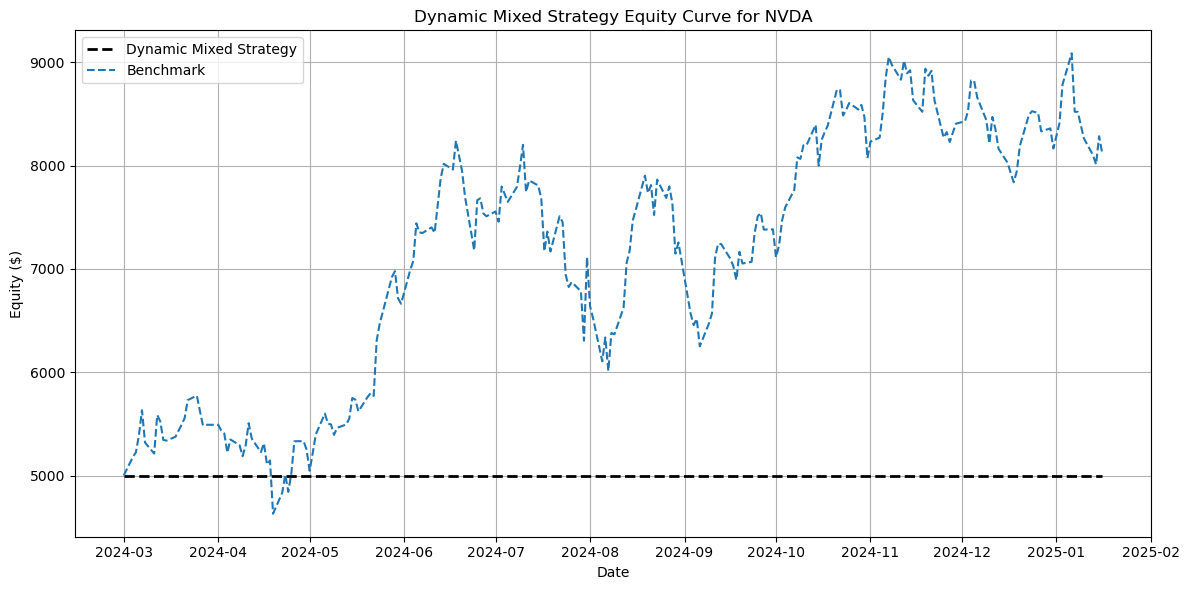

Final Benchmark Strategy return: 1.62
Final Mixed Strategy return: 1.00
NVDA final equity: 5000.00 -> Simple Return: 1.0000

--- Processing SOFI ---
SMA cumulative log return: 0.0660
RSI cumulative log return: 0.1734
EMA cumulative log return: -0.4814
BOLL cumulative log return: 0.1901
MACD cumulative log return: -0.3182
Benchmark cumulative log return: 0.1267
Updated weights: {'SMA': np.float64(0.07907200688742035), 'RSI': np.float64(0.20784180021249044), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.22787492193136713), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.4852112709687221)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.07907200688742035), 'RSI': np.float64(0.20784180021249044), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.22787492193136713), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.4852112709687221)}
SMA cumulative log return: 0.0193
RSI cumulative log return: 0.2180
EMA cumulative log return: -0.5281
BOLL cumulative log return: 0.143

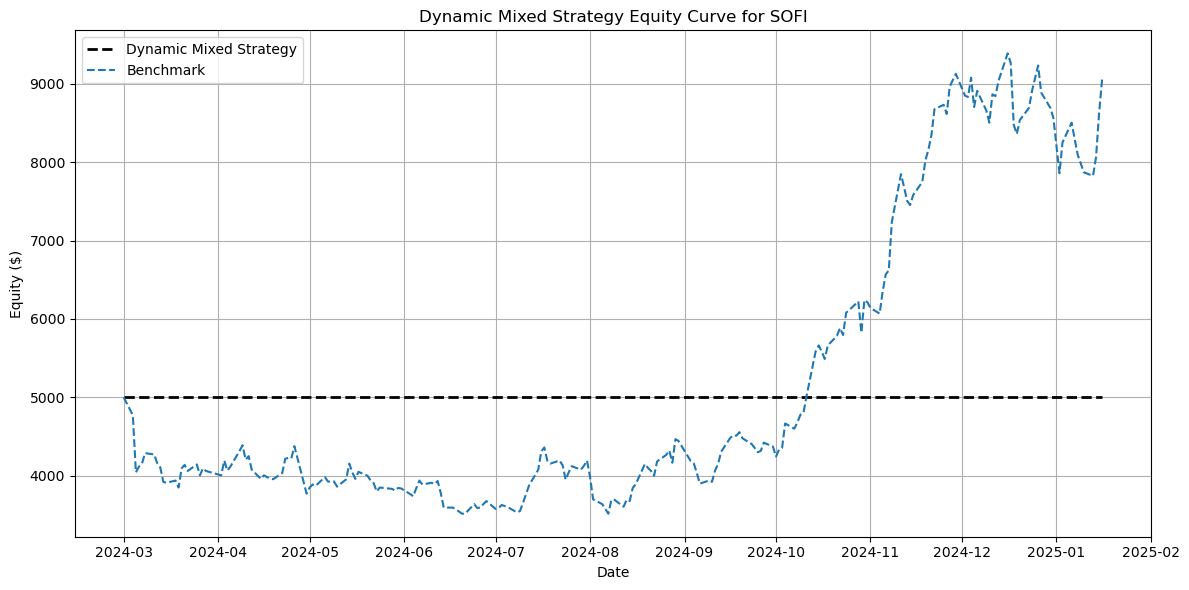

Final Benchmark Strategy return: 1.81
Final Mixed Strategy return: 1.00
SOFI final equity: 5000.00 -> Simple Return: 1.0000

--- Processing AMZN ---
SMA cumulative log return: -0.0610
RSI cumulative log return: -0.1530
EMA cumulative log return: -0.0124
BOLL cumulative log return: 0.1585
MACD cumulative log return: 0.0056
Benchmark cumulative log return: 0.1410
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.34633220277619187), 'MACD': np.float64(0.012162786027973979), 'Benchmark': np.float64(0.6415050111958343)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.34633220277619187), 'MACD': np.float64(0.012162786027973979), 'Benchmark': np.float64(0.6415050111958343)}
SMA cumulative log return: -0.0646
RSI cumulative log return: -0.1494
EMA cumulative log return: -0.0160
BOLL cumulative log return: 0.1621
MACD cumulative log retur

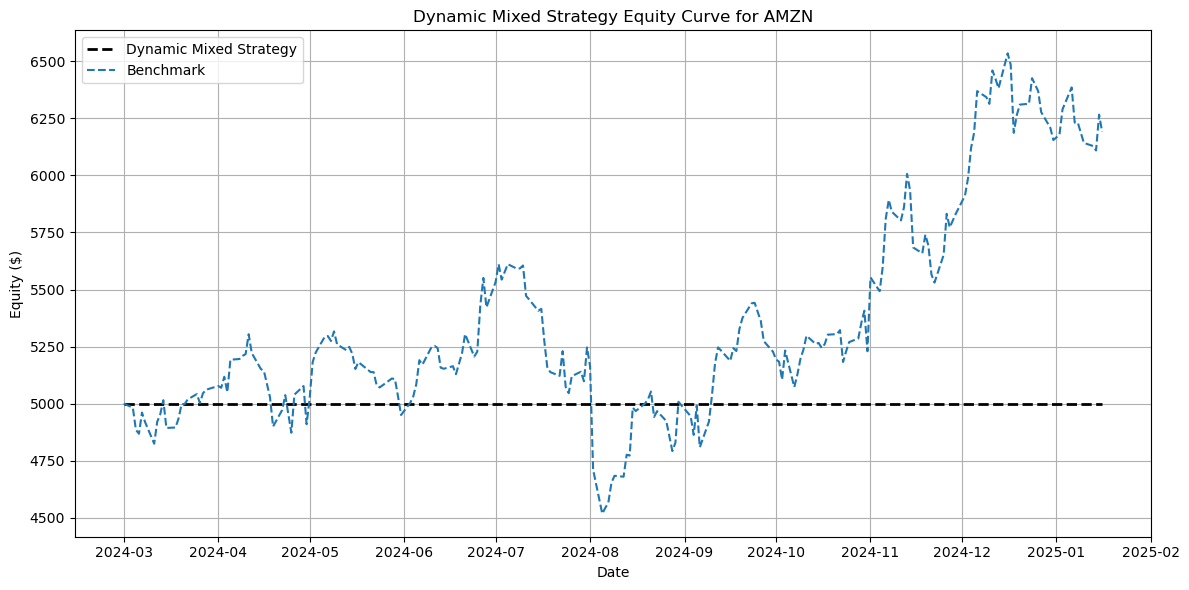

Final Benchmark Strategy return: 1.24
Final Mixed Strategy return: 1.00
AMZN final equity: 5000.00 -> Simple Return: 1.0000

--- Processing XOM ---
SMA cumulative log return: -0.0026
RSI cumulative log return: -0.1123
EMA cumulative log return: 0.0048
BOLL cumulative log return: 0.1096
MACD cumulative log return: 0.0313
Benchmark cumulative log return: 0.1079
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.01271456637718066), 'BOLL': np.float64(0.28806675338893784), 'MACD': np.float64(0.08233018924383596), 'Benchmark': np.float64(0.6168884909900456)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.01271456637718066), 'BOLL': np.float64(0.28806675338893784), 'MACD': np.float64(0.08233018924383596), 'Benchmark': np.float64(0.6168884909900456)}
SMA cumulative log return: -0.0166
RSI cumulative log return: -0.0985
EMA cumulative log return: -0.0092
BOLL cumulative log return: 0.09

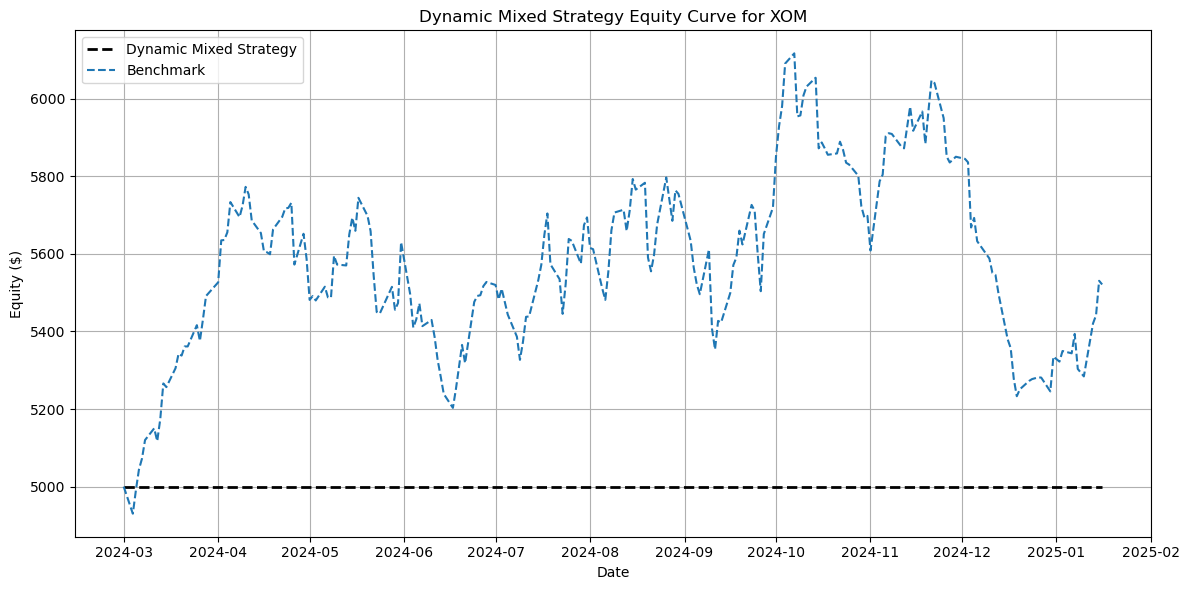

Final Benchmark Strategy return: 1.10
Final Mixed Strategy return: 1.00
XOM final equity: 5000.00 -> Simple Return: 1.0000

--- Processing TSLA ---
SMA cumulative log return: 0.1106
RSI cumulative log return: -0.0207
EMA cumulative log return: 0.0468
BOLL cumulative log return: -0.0299
MACD cumulative log return: 0.0415
Benchmark cumulative log return: -0.0299
Updated weights: {'SMA': np.float64(0.37077747645329834), 'RSI': np.float64(0.0), 'EMA': np.float64(0.1568485087506414), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.13904068146272686), 'Benchmark': np.float64(0.3333333333333333)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.37077747645329834), 'RSI': np.float64(0.0), 'EMA': np.float64(0.1568485087506414), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.13904068146272686), 'Benchmark': np.float64(0.3333333333333333)}
SMA cumulative log return: 0.0364
RSI cumulative log return: 0.0484
EMA cumulative log return: -0.0275
BOLL cumulative log return: -0.1042

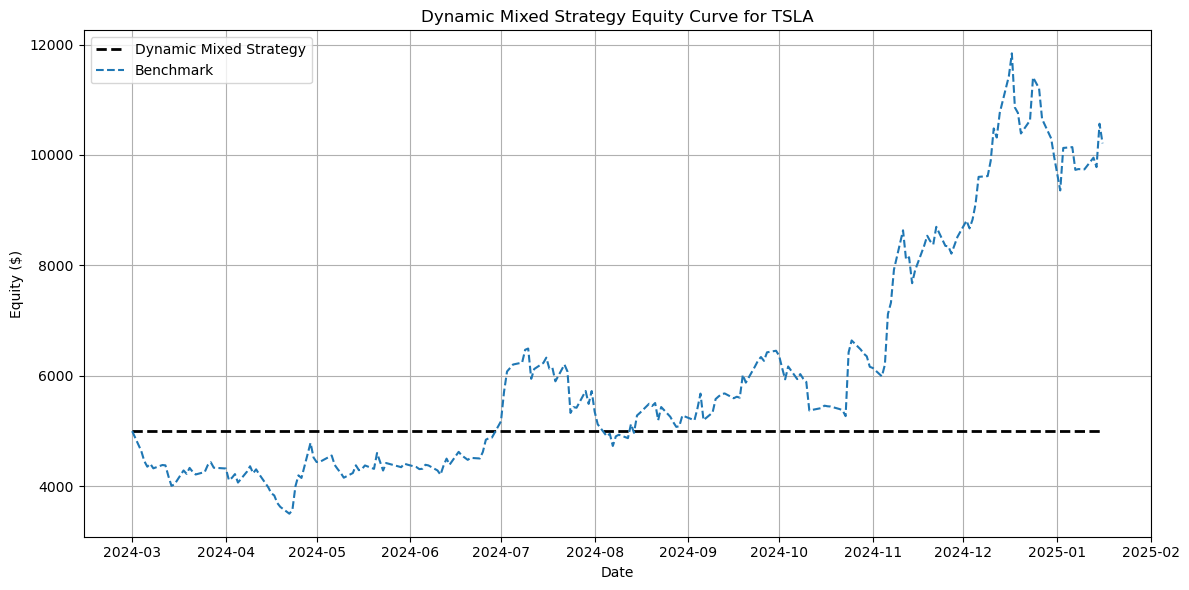

Final Benchmark Strategy return: 2.04
Final Mixed Strategy return: 1.00
TSLA final equity: 5000.00 -> Simple Return: 1.0000

--- Processing BA ---
SMA cumulative log return: 0.0477
RSI cumulative log return: -0.0401
EMA cumulative log return: -0.2020
BOLL cumulative log return: -0.0720
MACD cumulative log return: -0.1199
Benchmark cumulative log return: -0.0720
Updated weights: {'SMA': np.float64(0.6666666666666666), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.3333333333333333)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.6666666666666666), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.3333333333333333)}
SMA cumulative log return: 0.0450
RSI cumulative log return: -0.0374
EMA cumulative log return: -0.2047
BOLL cumulative log return: -0.0693
MACD cumulative log return: -0.1172
Benchmark cumulative log 

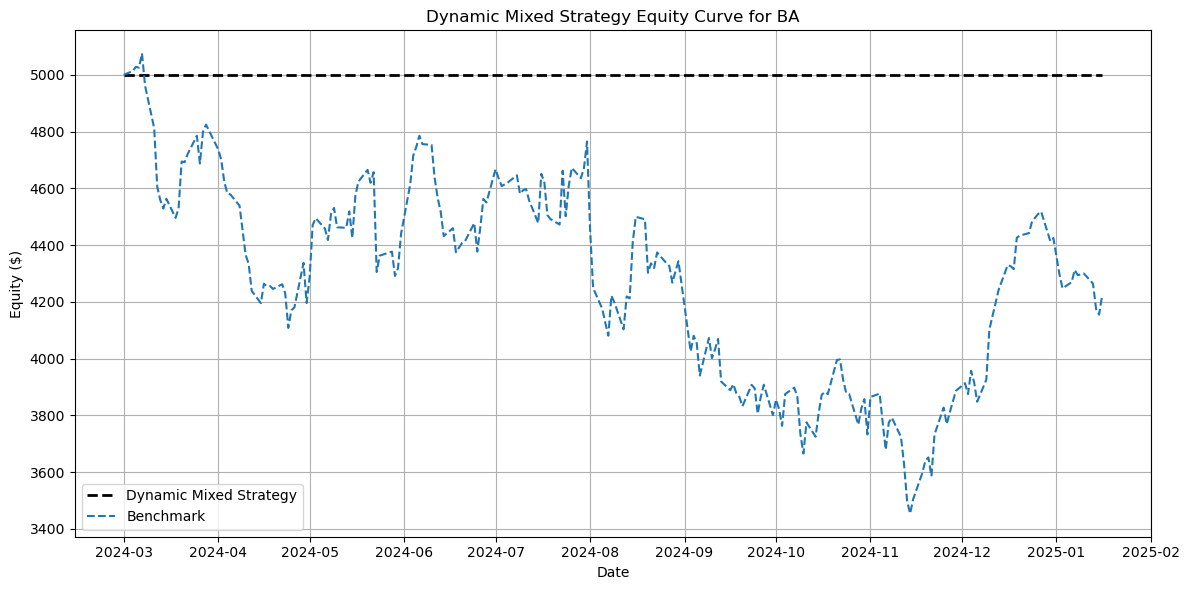

Final Benchmark Strategy return: 0.84
Final Mixed Strategy return: 1.00
BA final equity: 5000.00 -> Simple Return: 1.0000

--- Processing CAT ---
SMA cumulative log return: -0.0778
RSI cumulative log return: -0.1603
EMA cumulative log return: 0.0350
BOLL cumulative log return: 0.1375
MACD cumulative log return: 0.0550
Benchmark cumulative log return: 0.1539
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0611659647421386), 'BOLL': np.float64(0.24032322267567882), 'MACD': np.float64(0.09617301358032494), 'Benchmark': np.float64(0.6023377990018576)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0611659647421386), 'BOLL': np.float64(0.24032322267567882), 'MACD': np.float64(0.09617301358032494), 'Benchmark': np.float64(0.6023377990018576)}
SMA cumulative log return: -0.0720
RSI cumulative log return: -0.1661
EMA cumulative log return: 0.0408
BOLL cumulative log return: 0.1317
MA

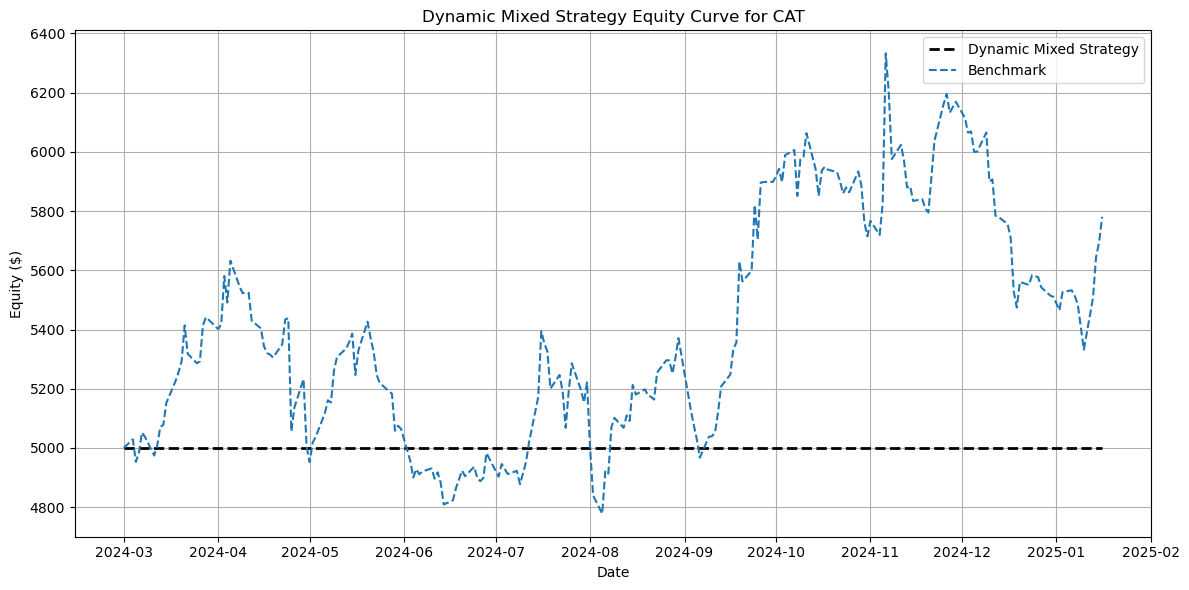

Final Benchmark Strategy return: 1.16
Final Mixed Strategy return: 1.00
CAT final equity: 5000.00 -> Simple Return: 1.0000

--- Processing WMT ---
SMA cumulative log return: -0.0032
RSI cumulative log return: -0.0224
EMA cumulative log return: 0.0346
BOLL cumulative log return: 0.1070
MACD cumulative log return: 0.0353
Benchmark cumulative log return: 0.0821
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.08896994165063099), 'BOLL': np.float64(0.2754017256760278), 'MACD': np.float64(0.09100210775830476), 'Benchmark': np.float64(0.5446262249150365)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.08896994165063099), 'BOLL': np.float64(0.2754017256760278), 'MACD': np.float64(0.09100210775830476), 'Benchmark': np.float64(0.5446262249150365)}
SMA cumulative log return: 0.0059
RSI cumulative log return: -0.0316
EMA cumulative log return: 0.0253
BOLL cumulative log return: 0.1161
MA

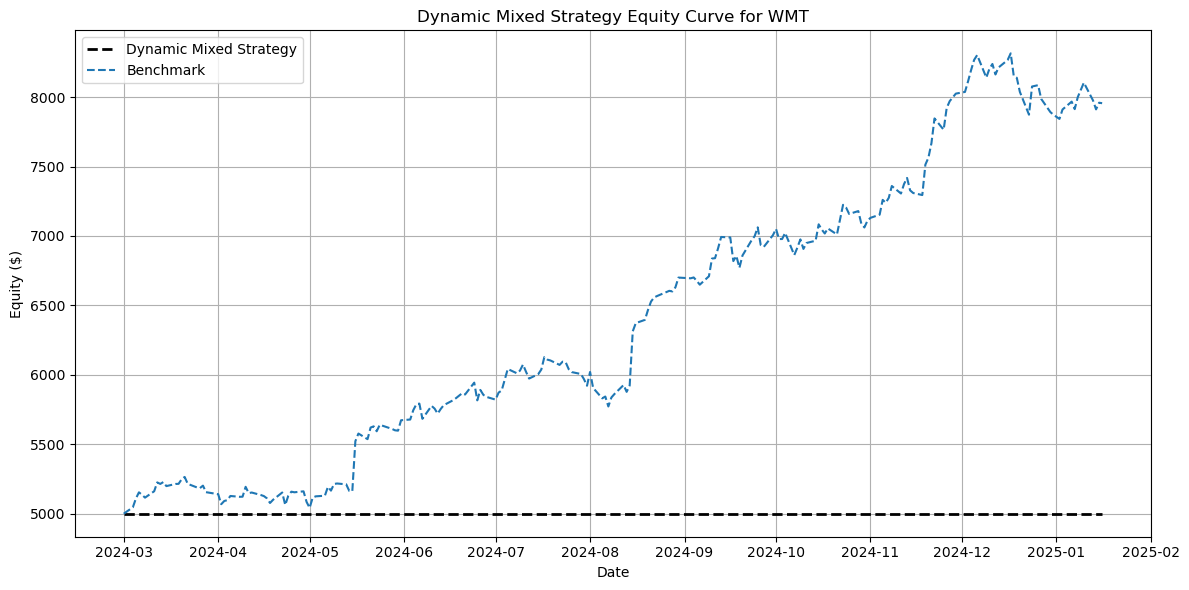

Final Benchmark Strategy return: 1.59
Final Mixed Strategy return: 1.00
WMT final equity: 5000.00 -> Simple Return: 1.0000

--- Processing CVX ---
SMA cumulative log return: -0.0416
RSI cumulative log return: -0.0572
EMA cumulative log return: -0.0610
BOLL cumulative log return: 0.0916
MACD cumulative log return: 0.0432
Benchmark cumulative log return: 0.0916
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.26972307138293106), 'MACD': np.float64(0.1272205239008046), 'Benchmark': np.float64(0.6030564047162644)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.0), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.26972307138293106), 'MACD': np.float64(0.1272205239008046), 'Benchmark': np.float64(0.6030564047162644)}
SMA cumulative log return: -0.0677
RSI cumulative log return: -0.0318
EMA cumulative log return: -0.0356
BOLL cumulative log return: 0.0656
MACD cumulative log return: 0.0

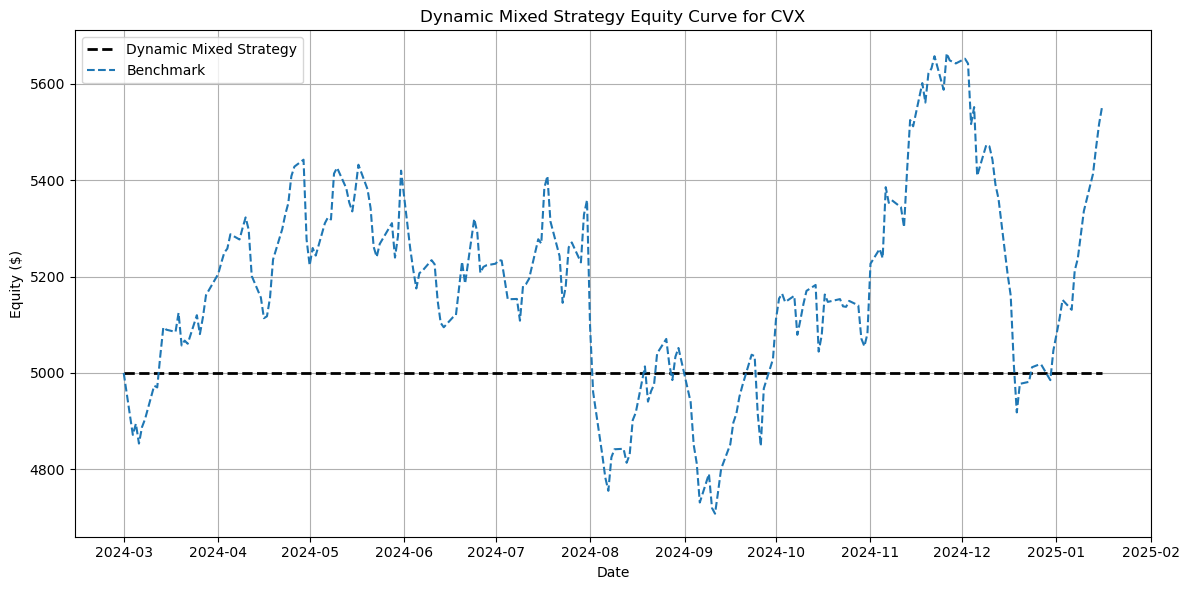

Final Benchmark Strategy return: 1.11
Final Mixed Strategy return: 1.00
CVX final equity: 5000.00 -> Simple Return: 1.0000

--- Processing UNH ---
SMA cumulative log return: -0.0679
RSI cumulative log return: 0.1042
EMA cumulative log return: -0.0016
BOLL cumulative log return: -0.0468
MACD cumulative log return: -0.0816
Benchmark cumulative log return: -0.0468
Updated weights: {'SMA': np.float64(0.0), 'RSI': np.float64(0.6666666666666666), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.3333333333333333)}
New weights for block starting 2024-03-01 00:00:00: {'SMA': np.float64(0.0), 'RSI': np.float64(0.6666666666666666), 'EMA': np.float64(0.0), 'BOLL': np.float64(0.0), 'MACD': np.float64(0.0), 'Benchmark': np.float64(0.3333333333333333)}
SMA cumulative log return: -0.0837
RSI cumulative log return: 0.0884
EMA cumulative log return: 0.0139
BOLL cumulative log return: -0.0626
MACD cumulative log return: -0.0660
Benchmark cumulative log r

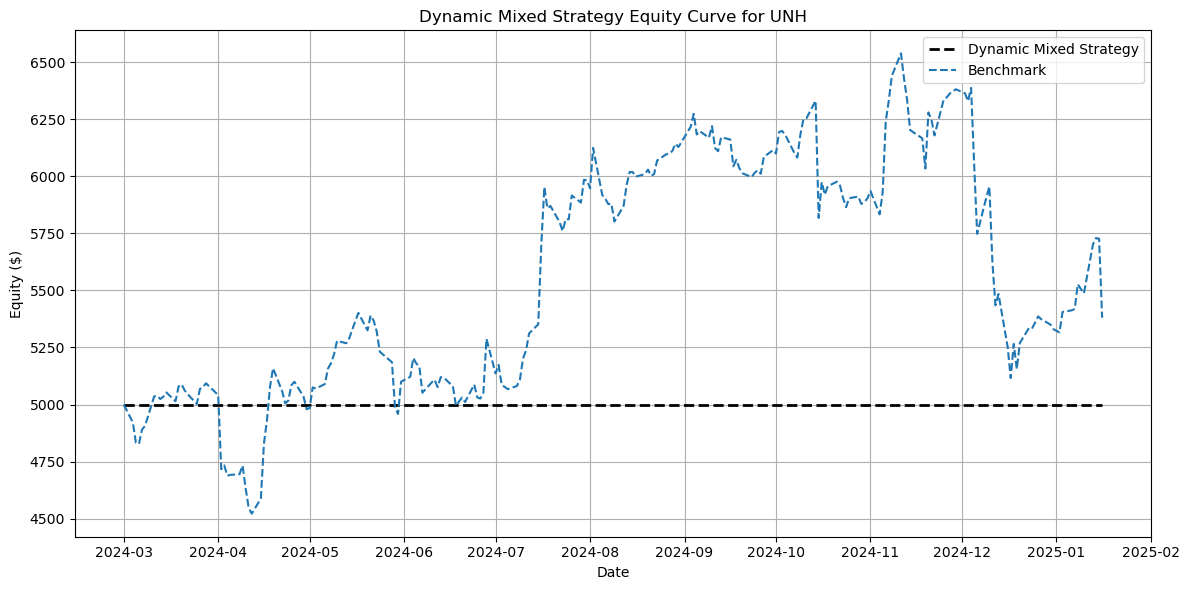

Final Benchmark Strategy return: 1.08
Final Mixed Strategy return: 1.00
UNH final equity: 5000.00 -> Simple Return: 1.0000


{'NVDA': np.float64(1.0),
 'SOFI': np.float64(1.0),
 'AMZN': np.float64(1.0),
 'XOM': np.float64(1.0),
 'TSLA': np.float64(1.0),
 'BA': np.float64(1.0),
 'CAT': np.float64(1.0),
 'WMT': np.float64(1.0),
 'CVX': np.float64(1.0),
 'UNH': np.float64(1.0)}

In [23]:
sim_results, portfolio_returns = generate_dynamic_mixed_strategy_portfolio(top10_tickers, train_df, test_df, initial_investment=5000, update_interval=1)
portfolio_returns

In [24]:
sim_results

{'NVDA':             Position  Equity  SimpleReturn  BenchmarkEquity
 2024-03-01  1.000000  5000.0           1.0      5000.000000
 2024-03-04  0.505227  5000.0           1.0      5179.754218
 2024-03-05  1.000000  5000.0           1.0      5224.421490
 2024-03-06  0.568207  5000.0           1.0      5390.700523
 2024-03-07  0.676241  5000.0           1.0      5631.914297
 ...              ...     ...           ...              ...
 2025-01-10  0.811125  5000.0           1.0      8263.767276
 2025-01-13  0.722994  5000.0           1.0      8100.814132
 2025-01-14  0.708135  5000.0           1.0      8011.433310
 2025-01-15  0.754581  5000.0           1.0      8283.832451
 2025-01-16  0.728225  5000.0           1.0      8121.487936
 
 [221 rows x 4 columns],
 'SOFI':             Position  Equity  SimpleReturn  BenchmarkEquity
 2024-03-01  0.584316  5000.0           1.0      5000.000000
 2024-03-04  0.369181  5000.0           1.0      4771.968934
 2024-03-05 -0.333333  5000.0           1.

# 5. Portfolio Management

In [25]:
def update_daily_portfolio_state(date, simulation_results, allocation_per_stock):
    """
    For the given date, this function extracts the per-stock net position (the "Position" column)
    and equity from each ticker’s simulation results (each is a DataFrame with index being dates).

    For each stock:
      - If Position > 0, the stock is in a long state; if Position < 0, in a short state.
      - Free (uninvested) capital = 1 - |Position|
      - The value associated with the stock is given by its simulated equity.

    Using these values (assuming each stock is allocated 'allocation_per_stock'),
    the function computes:
      • Long Value = (Position if positive) * allocation_per_stock
      • Short Value = (absolute Position if negative) * allocation_per_stock
      • Cash (free capital) = (1 - |Position|) * allocation_per_stock
      • Total Value = the simulated equity for that stock.

    Then, aggregates across stocks:
      - Total Long = sum over stocks with positive positions,
      - Total Short = sum over stocks with negative positions (expressed as a positive number),
      - Total Cash = sum of free capital across stocks,
      - Total Portfolio Value = sum of simulated equity for all stocks.

    Returns:
        dict: A dictionary with keys:
            'Date', 'Long', 'Short', 'Cash', 'Total'
          and also (optionally) a per-stock breakdown dictionary.
    """
    state = {"Date": date, "Long": 0, "Short": 0, "Cash": 0, "Total": 0}
    per_stock = {}

    for ticker, sim_df in simulation_results.items():
        # Check if the given date exists in the simulation result
        if date not in sim_df.index:
            continue
        pos = sim_df.loc[date, "Position"]
        equity = sim_df.loc[date, "Equity"]
        # For each stock, assume allocated capital is normalized to 1; then scale using allocation_per_stock.
        long_val = max(pos, 0) * allocation_per_stock
        short_val = -min(pos, 0) * allocation_per_stock  # note: pos < 0 gives positive short value
        cash = (1 - abs(pos)) * allocation_per_stock  # free or uninvested capital
        bench = sim_df.loc[date, "BenchmarkEquity"]
        per_stock[ticker] = {"Position": pos, "Equity": equity, "Long": long_val, "Short": short_val, "Cash": cash, "BenchmarkEquity": bench}

        # Aggregate values
        state["Long"] += long_val
        state["Short"] += short_val
        state["Cash"] += cash
        state["Total"] += equity  # total portfolio value for that stock is its simulated equity

    # Optionally, one might decide only to record days where there is a change in position.
    return {"daily_state": state, "per_stock": per_stock}

In [26]:
def simulate_portfolio_over_period(tickers, simulation_results, allocation_per_stock):
    """
    Given a list of tickers and simulation_results (a dictionary mapping each ticker to its simulation DataFrame),
    iterate over all dates in the union of simulation indices and compute the daily portfolio state using
    update_daily_portfolio_state.

    Returns:
         pd.DataFrame: A DataFrame with columns Date, Long, Short, Cash, Total.
    """
    all_dates = set()
    for ticker in tickers:
        df = simulation_results.get(ticker)
        if df is not None:
            all_dates = all_dates.union(set(df.index))
    all_dates = sorted(list(all_dates))

    daily_states = []
    for dt in all_dates:
        state_info = update_daily_portfolio_state(dt, simulation_results, allocation_per_stock)
        daily_states.append(state_info)

    # Build aggregated DataFrame for portfolio-level records.
    rows = []
    for entry in daily_states:
        row = entry["daily_state"].copy()
        # Also include each stock’s position with column name "ticker_Position".
        for ticker, stats in entry["per_stock"].items():
            row[f"{ticker}_Position"] = stats.get("Position")
            row[f"{ticker}_Equity"] = stats.get("Equity")
            row[f"{ticker}_Benchmark_Equity"] = stats.get("BenchmarkEquity")
        rows.append(row)

    trade_doc_df = pd.DataFrame(rows)
    trade_doc_df.sort_values("Date", inplace=True)
    trade_doc_df.reset_index(drop=True, inplace=True)
    return trade_doc_df

In [27]:
def generate_trade_documentation_table(trade_doc_df, only_active=False, activity_threshold=1e-4):
    """
    Processes the trade documentation DataFrame to include positions by stock as separate columns.

    Parameters:
        trade_doc_df (pd.DataFrame): DataFrame with aggregated columns (Date, Long, Short, Cash, Total)
                                     and additional columns for per-stock positions (e.g. "NVDA_Position", etc.).
        only_active (bool): If True, only keep rows where total activity (Long+Short) changes significantly.
        activity_threshold (float): Threshold to filter out minor changes.

    Returns:
        pd.DataFrame: The final trade documentation table.
    """
    if only_active:
        active_rows = [True]
        prev_invested = None
        for i, row in trade_doc_df.iterrows():
            current_invested = row["Long"] + row["Short"]
            if prev_invested is None or abs(current_invested - prev_invested) > activity_threshold:
                active_rows.append(True)
            else:
                active_rows.append(False)
            prev_invested = current_invested
        filtered_df = trade_doc_df[active_rows].copy()
        filtered_df.reset_index(drop=True, inplace=True)
        return filtered_df
    else:
        return trade_doc_df

In [28]:
allocation_per_stock = 5000
trade_doc = simulate_portfolio_over_period(top10_tickers, sim_results, allocation_per_stock)
portfolio = generate_trade_documentation_table(trade_doc, only_active=False)
equity_cols = [f"{ticker}_Benchmark_Equity" for ticker in top10_tickers]
portfolio["Benchmark_Equity"] = portfolio[equity_cols].sum(axis=1)
portfolio.set_index("Date", inplace=True)
portfolio

,Long,Short,Cash,Total,NVDA_Position,NVDA_Equity,NVDA_Benchmark_Equity,SOFI_Position,SOFI_Equity,SOFI_Benchmark_Equity,...,WMT_Position,WMT_Equity,WMT_Benchmark_Equity,CVX_Position,CVX_Equity,CVX_Benchmark_Equity,UNH_Position,UNH_Equity,UNH_Benchmark_Equity,Benchmark_Equity
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,34893.123088,1666.666667,13440.210245,50000.0,1.000000,5000.0,5000.000000,0.584316,5000.0,5000.000000,...,0.822060,5000.0,5000.000000,0.745559,5000.0,5000.000000,1.000000,5000.0,5000.000000,50000.000000
2024-03-04,29575.728687,1666.666667,18757.604647,50000.0,0.505227,5000.0,5179.754218,0.369181,5000.0,4771.968934,...,1.000000,5000.0,5045.949915,0.541983,5000.0,4871.409583,0.818570,5000.0,4921.761555,49387.651731
2024-03-05,34932.294341,3333.333333,11734.372325,50000.0,1.000000,5000.0,5224.421490,-0.333333,5000.0,4043.381627,...,1.000000,5000.0,5108.917612,0.583767,5000.0,4894.640777,0.583669,5000.0,4832.696284,48420.641618
2024-03-06,30897.447693,3333.333333,15769.218974,50000.0,0.568207,5000.0,5390.700523,-0.333333,5000.0,4115.684251,...,1.000000,5000.0,5154.016408,0.508558,5000.0,4853.412943,0.568486,5000.0,4827.078833,48617.798497
2024-03-07,33429.759860,3236.277879,13333.962261,50000.0,0.676241,5000.0,5631.914297,-0.313922,5000.0,4154.616229,...,1.000000,5000.0,5136.147179,0.571615,5000.0,4887.441915,0.740028,5000.0,4890.200436,49269.407076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,31267.922782,159.516827,18572.560391,50000.0,0.811125,5000.0,8263.767276,1.000000,5000.0,7869.855384,...,0.807603,5000.0,8104.459328,0.698007,5000.0,5335.832659,-0.031903,5000.0,5486.502314,65858.810418
2025-01-13,35092.644085,138.270081,14769.085834,50000.0,0.722994,5000.0,8100.814132,1.000000,5000.0,7825.361540,...,0.772254,5000.0,7976.356477,0.753857,5000.0,5412.835571,-0.027654,5000.0,5701.983769,66289.073991
2025-01-14,34641.864796,63.875130,15294.260074,50000.0,0.708135,5000.0,8011.433310,1.000000,5000.0,8064.516334,...,0.754565,5000.0,7911.869568,0.233813,5000.0,5466.841549,-0.012775,5000.0,5729.379671,66334.993581


In [29]:
(portfolio["Cash"] >= 2 * portfolio["Short"]).value_counts()

True    221
Name: count, dtype: int64